In [9]:
pwd

'/global/u2/b/bharat/repos/networkutk'

In [1]:
# Calculating heatwaves for Resiliency
import xarray as xr
import numpy as np
import cftime
#import intake_esgf
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Set the matplotlib default font size
mpl.rcParams['font.size'] = 16

In [2]:
# Read coordinates
df= pd.read_csv('railonly.csv')
df_nodes = df[['dms_orig_string','dms_orig_coordinates']].drop_duplicates()
# Separate into latitude and longitude columns
df_nodes[['longitude', 'latitude']] = df_nodes['dms_orig_coordinates'].str.extract(r'\((-?\d+\.\d+),\s*(-?\d+\.\d+)\)')
# Convert columns to numeric if needed
df_nodes['longitude'] = pd.to_numeric(df_nodes['longitude'])
df_nodes['latitude'] = pd.to_numeric(df_nodes['latitude'])
# Convert negative longitudes to 0-360 range
df_nodes['longitude'] = df_nodes['longitude'] % 360
# Reset the index
df_nodes = df_nodes.reset_index(drop=True)

## Inputs

| Model 1         | Model 2         | Model 3        | Model 4           | Model 5         |
|-----------------|-----------------|----------------|--------------------|-----------------|
| ACCESS-CM2      | AWI-CM-1-1-MR   | CanESM5        | CNRM-CM6-1         | CNRM-ESM2-1     |
| EC-Earth3-Veg   | GFDL-CM4        | HadGEM3-GC31-LL| INM-CM4-8          | IPSL-CM6A-LR    |
| MIROC6          | MPI-ESM1-2-HR   | MRI-ESM2-0     | NorESM2-MM         | TaiESM1         |
| ACCESS-ESM1-5   | BCC-CSM2-MR     | CESM2-LENS     | CNRM-CM6-1-HR      | EC-Earth3       |
| FGOALS-g3       | GFDL-ESM4       | HadGEM3-GC31-MM| INM-CM5-0          | KACE-1-0-G      |
|          | MPI-ESM1-2-LR   | NorESM2-LM     | -                  | -               |

In [50]:
# which high res model you are interested in?
model_name = "GFDL-ESM4" #    GFDL-ESM4 
ssp_sce = "ssp585"

## Analyzed

| Model 1         | Model 2         | Model 3        | Model 4           | Model 5         |
|-----------------|-----------------|----------------|--------------------|-----------------|
| ACCESS-CM2      | AWI-CM-1-1-MR   | **CanESM5**        | CNRM-CM6-1         | CNRM-ESM2-1     |
| EC-Earth3-Veg   | GFDL-CM4        | HadGEM3-GC31-LL| INM-CM4-8          | **IPSL-CM6A-LR**    |
| **MIROC6**          | **MPI-ESM1-2-HR**   | MRI-ESM2-0     | NorESM2-MM         | ~~TaiESM1~~         |
| **ACCESS-ESM1-5**   | BCC-CSM2-MR     | ~~CESM2-LENS~~     | CNRM-CM6-1-HR      | EC-Earth3       |
| FGOALS-g3       | **GFDL-ESM4**       | HadGEM3-GC31-MM| **INM-CM5-0**          | KACE-1-0-G      |
|          | MPI-ESM1-2-LR   | **NorESM2-LM**     | -                  | -               |


In [51]:
file_pattern_hist = f'/global/cfs/cdirs/m3522/cmip6/LOCA2/{model_name}/0p0625deg/r1i1p1f1/historical/tasmax/*.nc'
file_pattern_future = f'/global/cfs/cdirs/m3522/cmip6/LOCA2/{model_name}/0p0625deg/r1i1p1f1/{ssp_sce}/tasmax/*.nc'


In [52]:
# Read datasets using xarray's open_mfdataset
ds_hist = xr.open_mfdataset(file_pattern_hist, 
                            combine='by_coords', 
                            decode_times=True,
                            use_cftime=True)
ds_future = xr.open_mfdataset(file_pattern_future, 
                              combine='by_coords',
                              decode_times=True,
                              use_cftime=True)

# Optional: concatenate historical and future datasets
ds_daily = xr.concat([ds_hist, ds_future], dim='time')

In [53]:
# Extract all coordinates as DataArray for vectorized selection
lats = xr.DataArray(df_nodes['latitude'].values, dims='points')
lons = xr.DataArray(df_nodes['longitude'].values, dims='points')

# Extract all tasmax values at once using vectorized nearest selection
tasmax_all = ds_daily['tasmax'].sel(lat=lats, lon=lons, method='nearest')

# 1. Define time periods
periods = {
    'hot_days_hist':    (cftime.DatetimeGregorian(1991, 1, 1), cftime.DatetimeGregorian(2020, 12, 31)),
    'hot_days_future':  (cftime.DatetimeGregorian(2021, 1, 1), cftime.DatetimeGregorian(2050, 12, 31)),
    'hot_days_future2': (cftime.DatetimeGregorian(2051, 1, 1), cftime.DatetimeGregorian(2080, 12, 31)),
#    'hot_days_future3': (cftime.DatetimeGregorian(2121, 1, 1), cftime.DatetimeGregorian(2150, 12, 31)),
}

# 2. Use DataArray > threshold once
threshold_kelvin = 35 + 273.15
# Boolean arrays: days above threshold
hot_mask = tasmax_all > threshold_kelvin  # shape: (time, node

# 3. Compute all sums in one pass
results = {}

for label, (start, end) in periods.items():
    print (label, " ... ")
    time_mask = (hot_mask['time'] >= start) & (hot_mask['time'] <= end)
    result = hot_mask.sel(time=time_mask).sum(dim='time')  # shape: (node,)
    results[label] = result.compute().values  # eager load only once

# 4. Construct DataFrame
df_nodes_daily = df_nodes.copy(deep=True)
for label, arr in results.items():
    df_nodes_daily[label] = arr.astype(int)  # or float if fractional

# Calculate the change in the number of hot days
df_nodes_daily['hot_days_change'] = df_nodes_daily['hot_days_future'] - df_nodes_daily['hot_days_hist']
df_nodes_daily['hot_days_change2'] = df_nodes_daily['hot_days_future2'] - df_nodes_daily['hot_days_hist']
#df_nodes_daily['hot_days_change3'] = df_nodes_daily['hot_days_future3'] - df_nodes_daily['hot_days_hist']
df_nodes_daily.to_csv(f"LOCA2/{model_name}_hot_days_daily.csv")

hot_days_hist  ... 
hot_days_future  ... 
hot_days_future2  ... 


## Plots

Object `cbar.set_extent` not found.


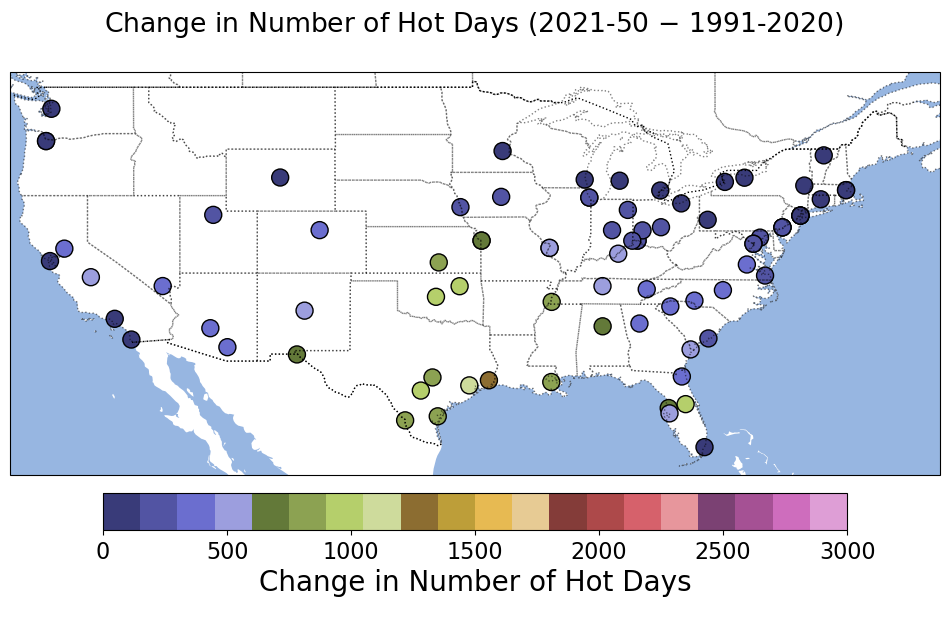

In [54]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())

#ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':' , alpha =.5 )
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
vmin_val =0; vmax_val = 3000
scatter = ax.scatter(df_nodes_daily['longitude'], df_nodes_daily['latitude'], 
                     c=df_nodes_daily['hot_days_change'], cmap='tab20b', 
                     s=150, edgecolor='k', transform=ccrs.PlateCarree(),
                    vmin=vmin_val, vmax = vmax_val)


# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.03, shrink = 0.8)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)
cbar.ax.tick_params(labelsize=16)
cbar.set_extent?

# Add titles and labels
plt.title('Change in Number of Hot Days (2021-50 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()
fig.savefig( f'LOCA2/{model_name}_Change_HotDays_2021.pdf',bbox_inches='tight')
fig.savefig( f'LOCA2/{model_name}_Change_HotDays_2021.png',bbox_inches='tight')

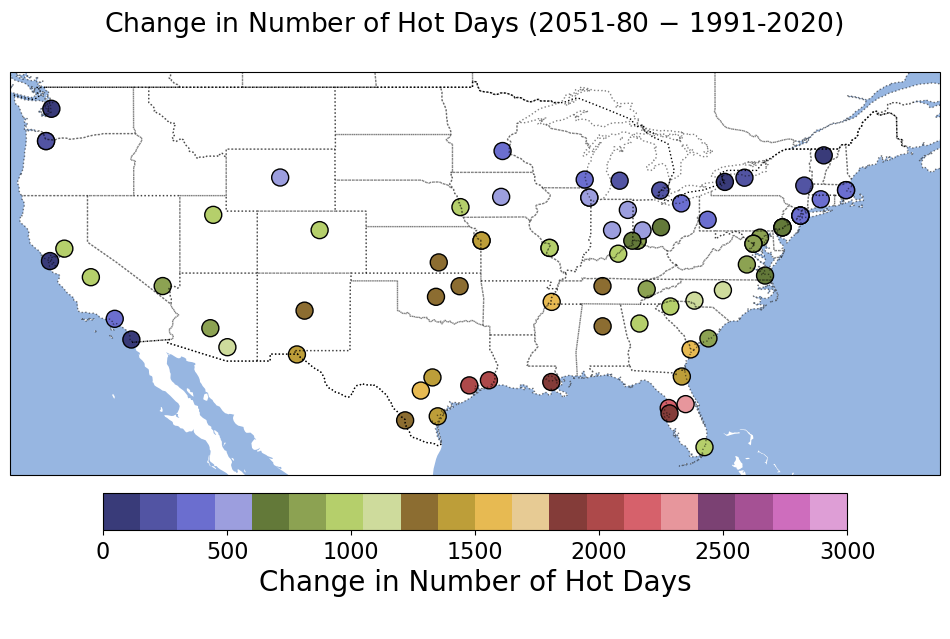

In [55]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':' , alpha =.5 )
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
vmin_val =0; vmax_val = 3000
scatter = ax.scatter(df_nodes_daily['longitude'], df_nodes_daily['latitude'], 
                     c=df_nodes_daily['hot_days_change2'], cmap='tab20b', 
                     s=150, edgecolor='k', transform=ccrs.PlateCarree(),
                    vmin=vmin_val, vmax = vmax_val)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.03, shrink = 0.8)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# Add titles and labels
plt.title('Change in Number of Hot Days (2051-80 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig.savefig( f'LOCA2/{model_name}_Change_HotDays_2051.pdf',bbox_inches='tight')
fig.savefig( f'LOCA2/{model_name}_Change_HotDays_2051.png',bbox_inches='tight')

plt.show()